In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt

import lenspyx
from lenspyx.lensing import get_geom

import healpy as hp

import shtns
import pysht

# Type I

In [2]:
"""
Demonstrate the type 1 NUFFT using cuFINUFFT
"""

import numpy as np

import pycuda.autoinit
from pycuda.gpuarray import GPUArray, to_gpu

from cufinufft import cufinufft

# Set up parameters for problem.
N1, N2 = 59, 61                 # Size of uniform grid
M = 100                         # Number of nonuniform points
n_transf = 2                    # Number of input arrays
eps = 1e-6                      # Requested tolerance
dtype = np.float32              # Datatype (real)
complex_dtype = np.complex64    # Datatype (complex)

# Generate coordinates of non-uniform points.
kx = np.random.uniform(-np.pi, np.pi, size=M)
ky = np.random.uniform(-np.pi, np.pi, size=M)

# Generate source strengths.
c = (np.random.standard_normal((n_transf, M))
     + 1j * np.random.standard_normal((n_transf, M)))

# Cast to desired datatype.
kx = kx.astype(dtype)
ky = ky.astype(dtype)
c = c.astype(complex_dtype)

# Allocate memory for the uniform grid on the GPU.
fk_gpu = GPUArray((n_transf, N1, N2), dtype=complex_dtype)

# Initialize the plan and set the points.
plan = cufinufft(1, (N1, N2), n_transf, eps=eps, dtype=dtype)
plan.set_pts(to_gpu(kx), to_gpu(ky))

# Execute the plan, reading from the strengths array c and storing the
# result in fk_gpu.
plan.execute(to_gpu(c), fk_gpu)

# Retreive the result from the GPU.
fk = fk_gpu.get()

# Check accuracy of the transform at position (nt1, nt2).
nt1 = int(0.37 * N1)
nt2 = int(0.26 * N2)

for i in range(n_transf):
    # Calculate the true value of the type 1 transform at the uniform grid
    # point (nt1, nt2), which corresponds to the coordinate nt1 - N1 // 2 and
    # nt2 - N2 // 2.
    x, y = nt1 - N1 // 2, nt2 - N2 // 2
    fk_true = np.sum(c[i] * np.exp(1j * (x * kx + y * ky)))

    # Calculate the absolute and relative error.
    err = np.abs(fk[i, nt1, nt2] - fk_true)
    rel_err = err / np.max(np.abs(fk[i]))

    print(f"[{i}] Absolute error on mode [{nt1}, {nt2}] is {err:.3g}")
    print(f"[{i}] Relative error on mode [{nt1}, {nt2}] is {rel_err:.3g}")

    assert(rel_err < 10 * eps)

[0] Absolute error on mode [21, 15] is 3.3e-05
[0] Relative error on mode [21, 15] is 8.14e-07
[1] Absolute error on mode [21, 15] is 1.3e-05
[1] Relative error on mode [21, 15] is 3.21e-07


(2, 59, 61)

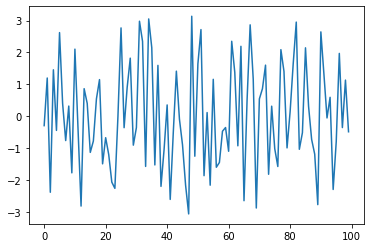

In [5]:
plt.plot(kx)

In [ ]:
plt.imshow(fk[0])

In [7]:
fk[0]

array([[  8.429497   +2.2750523j,   7.767778   +3.4984996j,
         -5.917145   +3.6287773j, ..., -17.545706  -10.937516j ,
          5.547226   +4.7015543j,   3.0560486 +13.632037j ],
       [ 15.667555  -21.624306j ,  10.964965   +1.1421117j,
        -16.621174   -6.361185j , ...,  -0.33963045+17.764282j ,
         -3.0892746  -8.101063j , -12.69894    -7.722195j ],
       [  3.2443755  +7.3679767j,  -6.3758616  -9.718589j ,
        -11.909618   -4.4297547j, ..., -11.429705  +14.27438j  ,
          5.080628   +0.7242162j,  -5.097507   -9.306669j ],
       ...,
       [ -4.7166343 -10.680415j ,  -7.991952   -6.508909j ,
          1.9483683 +20.372618j , ..., -18.708296  +13.745105j ,
         -7.557377  -22.962648j ,  -6.808643   -4.6208067j],
       [-12.877399   +7.832844j , -13.662436   -3.125886j ,
         -5.400474  +22.970896j , ..., -23.926498   +3.437457j ,
         27.96528    -5.0105186j,  -0.5415747  +4.4560494j],
       [-15.599986   +6.751316j ,  13.551672   +7.3622255j

## finufft

In [9]:
# Simple 1d1 python interface call
# Lu 02/07/20.

import time
import finufft as fp
import numpy as np

np.random.seed(42)

N = int(1e6)
M = int(1e5)
x = np.random.uniform(-np.pi, np.pi, M)
c = np.random.randn(M) + 1.j * np.random.randn(M)
F = np.zeros([N], dtype=np.complex128)       # allocate F (modes out)
n_modes = np.ones([1], dtype=np.int64)
n_modes[0] = N

strt = time.time()

#plan
plan = fp.Plan(1,(N,))

#set pts
plan.setpts(x)

#exec
plan.execute(c,F)

#timing
print("Finished nufft in {0:.2g} seconds. Checking..."
      .format(time.time()-strt))

#check error
n = 142519      # mode to check
Ftest = 0.0
# this is so slow...
for j in range(M):
    Ftest += c[j] * np.exp(n * x[j] * 1.j)
Fmax = np.max(np.abs(F))
err = np.abs((F[n + N // 2] - Ftest) / Fmax)
print("Error relative to max of F: {0:.2e}".format(err))


Finished nufft in 0.15 seconds. Checking...
Error relative to max of F: 3.68e-08


# Type II

In [ ]:
"""
Demonstrate the type 2 NUFFT using cuFINUFFT
"""

import numpy as np

import pycuda.autoinit
from pycuda.gpuarray import GPUArray, to_gpu

from cufinufft import cufinufft

# Set up parameters for problem.
N1, N2 = 37, 41                 # Size of uniform grid
M = 17                          # Number of nonuniform points
n_transf = 2                    # Number of input arrays
eps = 1e-6                      # Requested tolerance
dtype = np.float32              # Datatype (real)
complex_dtype = np.complex64    # Datatype (complex)

# Generate coordinates of non-uniform points.
kx = np.random.uniform(-np.pi, np.pi, size=M)
ky = np.random.uniform(-np.pi, np.pi, size=M)

# Generate grid values.
fk = (np.random.standard_normal((n_transf, N1, N2))
      + 1j * np.random.standard_normal((n_transf, N1, N2)))

# Cast to desired datatype.
kx = kx.astype(dtype)
ky = ky.astype(dtype)
fk = fk.astype(complex_dtype)

# Allocate memory for the nonuniform coefficients on the GPU.
c_gpu = GPUArray((n_transf, M), dtype=complex_dtype)

# Initialize the plan and set the points.
plan = cufinufft(2, (N1, N2), n_transf, eps=eps, dtype=dtype)
plan.set_pts(to_gpu(kx), to_gpu(ky))

# Execute the plan, reading from the uniform grid fk c and storing the result
# in c_gpu.
plan.execute(c_gpu, to_gpu(fk))

# Retreive the result from the GPU.
c = c_gpu.get()

# Check accuracy of the transform at index jt.
jt = M // 2

for i in range(n_transf):
    # Calculate the true value of the type 2 transform at the index jt.
    x, y = np.mgrid[-(N1 // 2):(N1 + 1) // 2, -(N2 // 2):(N2 + 1) // 2]
    c_true = np.sum(fk[i] * np.exp(-1j * (x * kx[jt] + y * ky[jt])))

    # Calculate the absolute and relative error.
    err = np.abs(c[i, jt] - c_true)
    rel_err = err / np.max(np.abs(c[i]))

    print(f"[{i}] Absolute error on point [{jt}] is {err:.3g}")
    print(f"[{i}] Relative error on point [{jt}] is {rel_err:.3g}")

    assert(rel_err < 10 * eps)